# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [70]:
# These libraries may be useful to you

from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

#import gensim
#import gensim.corpora as corpora
#from gensim.utils import simple_preprocess
#from gensim.models import CoherenceModel,LdaMulticore, Phrases 
#from gensim.models.phrases import Phraser 
#from gensim.corpora import Dictionary

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

In [73]:
# add any additional libaries you need here
import nltk
nltk.download("brown")
import warnings #turn off warnings
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\fkrasovsky\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [46]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5,topic_name=""):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        if topic_name=="":
            print("\nTopic %02d" % topic)
        else:
            print(f"Topic: {topic_name}")
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [80]:
#we can also use wordclouds to compare model-generated topics and predefined ones.
def wordcloud_topics(model, features, no_top_words=40,wc_title="wordcloud"):
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100,
         width=960, height=540,)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.title(f'{wc_title} - {topic}')
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [6]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [7]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [8]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))

<AxesSubplot:xlabel='category'>

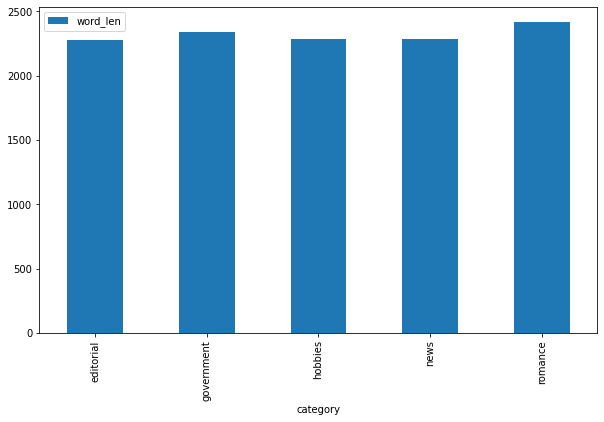

In [9]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [47]:
count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

c:\users\fkrasovsky\appdata\local\programs\python\python38\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [48]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: Count_text_vectors contains a count of each token for each document. For instance, if the word "apple" occurs in a document twice, we would see a value of 2 in the column representing that token for a given document. tfidf_text_vectors, meanwhile, contains the TF-IDF score of a given term in each document.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [49]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

### Assessing NMF Topics: Displaying Top Words

In [55]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


### Asessing NMF Topics: Wordcloud

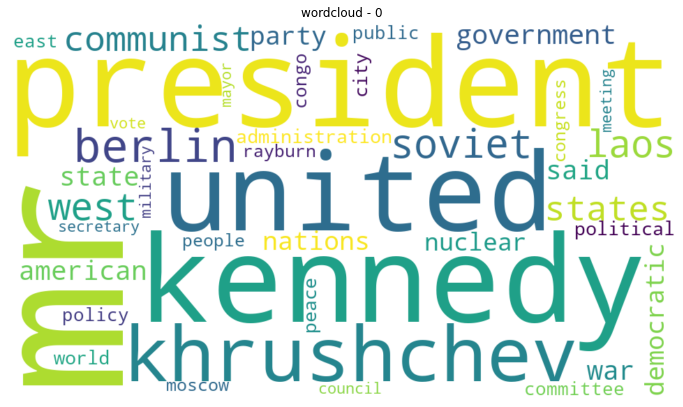

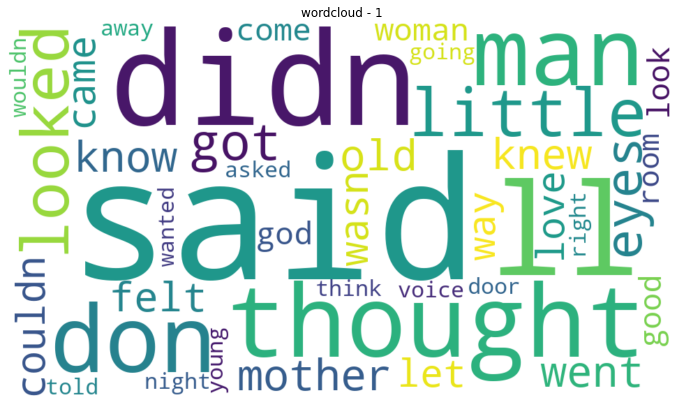

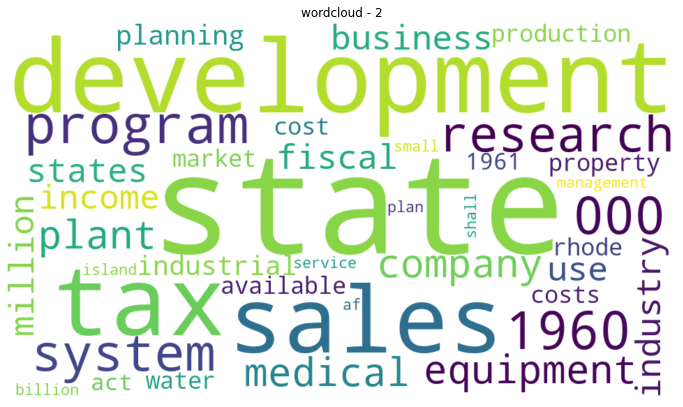

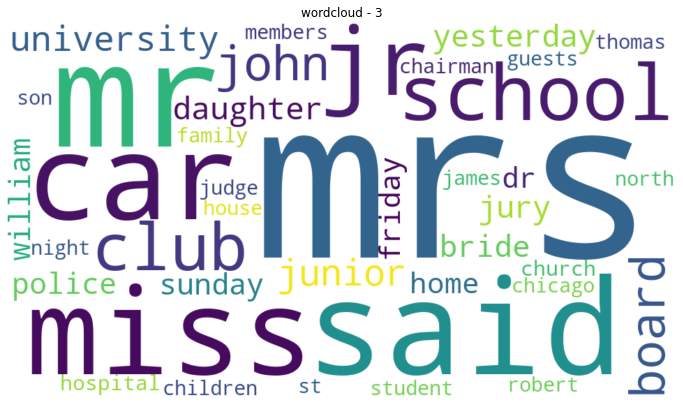

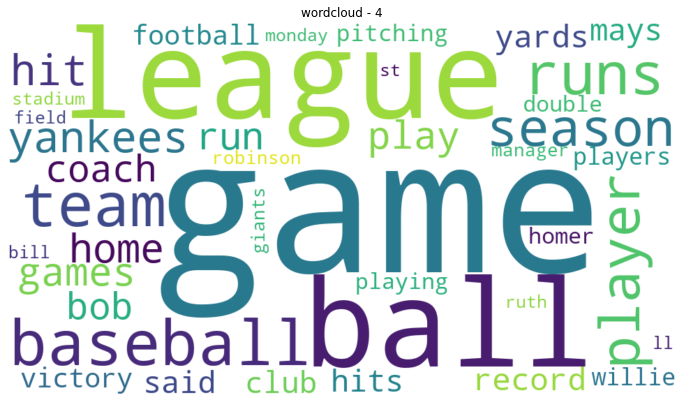

In [81]:
wordcloud_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())

Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

**Developer's Note:** We can approach this issue by attempting to create a 1-topic NMF for each of the categories that were pre-built into our dataframe, iteratintg over them and displaying topics for comparrison. We may need to change the min and max_df given that each category is smaller.

### Asessing Predefined Topics: Display Top Words

In [69]:
for cat in df['category'].unique():
    
    #get a section of our dataframe with a given category
    this_cat = df[df['category']==cat]
    
    #get text vectors for TFIDF
    this_tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
    this_tfidf_text_vectors = this_tfidf_text_vectorizer.fit_transform(this_cat['text'])
    
    this_nmf = NMF(n_components=1, random_state=672)
    W_this_matrix = this_nmf.fit_transform(this_tfidf_text_vectors)
    H_this_matrix = this_nmf.components_
    
    #display NMF results
    display_topics(
        model=this_nmf, 
        features=this_tfidf_text_vectorizer.get_feature_names_out(),
        topic_name=cat)

Topic: editorial
  mr (0.76)
  west (0.50)
  city (0.48)
  berlin (0.47)
  east (0.46)
Topic: government
  state (0.97)
  development (0.64)
  mr (0.52)
  business (0.48)
  service (0.47)
Topic: news
  mrs (0.68)
  mr (0.50)
  state (0.38)
  000 (0.36)
  school (0.28)
Topic: romance
  long (0.53)
  mother (0.50)
  room (0.48)
  mrs (0.43)
  right (0.43)
Topic: hobbies
  water (0.45)
  inch (0.42)
  house (0.41)
  design (0.34)
  place (0.31)


### Asessing Predefined Topics: Wordcloud

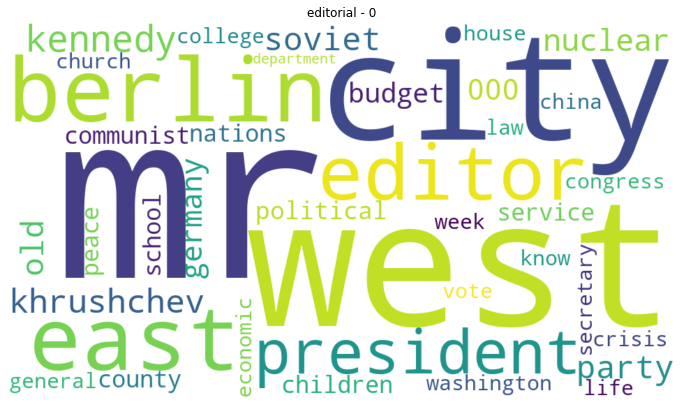

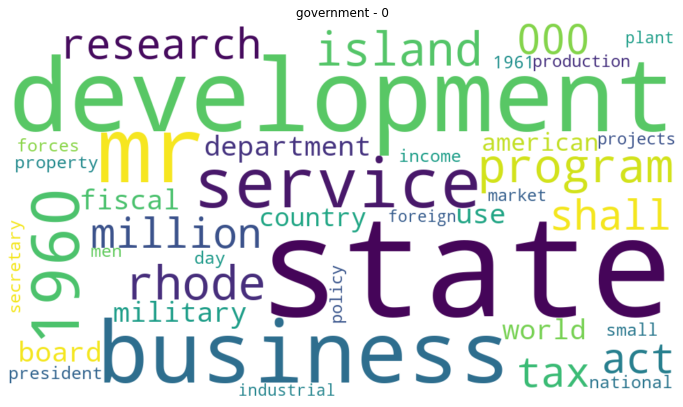

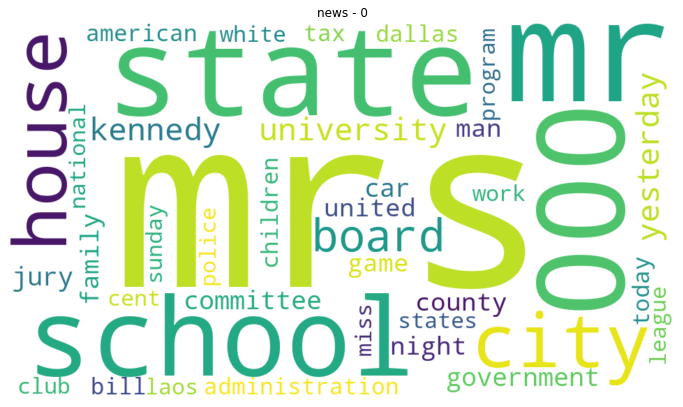

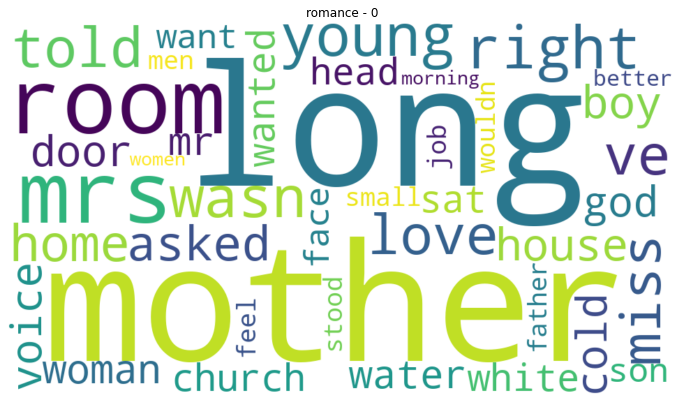

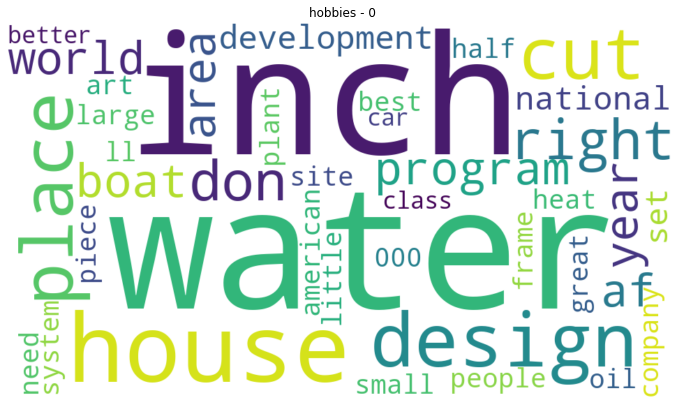

In [83]:
for cat in df['category'].unique():
    
    #get a section of our dataframe with a given category
    this_cat = df[df['category']==cat]
    
    #get text vectors for TFIDF
    this_tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
    this_tfidf_text_vectors = this_tfidf_text_vectorizer.fit_transform(this_cat['text'])
    
    this_nmf = NMF(n_components=1, random_state=672)
    W_this_matrix = this_nmf.fit_transform(this_tfidf_text_vectors)
    H_this_matrix = this_nmf.components_
    
    #display NMF results
    wordcloud_topics(this_nmf, this_tfidf_text_vectorizer.get_feature_names_out(),wc_title=cat)

Q: How does your five-topic NMF model compare to the original Brown categories? 

A: 
**Terminology**: NMF Output refers to the topic generated by our NMF model closest to the category present in the dataset. True category refers to the category present in the dataset.
1. Hobbies: The true category's top words differ from the NMF Output in that the former focuses more on boats, water, and houses as primary hobby areas. Wordcloud 4 is the closest topic from the NMF Output, and focuses mostly on sports.

2. Editorial - the true category overlaps with category 0 and category 3. The true category focuses on political discussion alongside with the true category for government, so it makes sense that these categories become mixed and dispersed across different NMF topics. The Editorial category overlaps with category 3 in that they both have the word "Mr" as a major component, and overlaps with category 0 as they both use words such as "President" and other politically relevant terms.

3. Government - This category overlaps significantly with NMF Category 2, as they both discuss development, the state, business, taxes, and mentions of rhode island and 1960, suggesting some salient political activity that occured during that time. This category has a pretty significant overlap with its NMF counterpart.

4. News - This true category seems to have overlap with categories 0 and 3 as well, suggesting that the line between News and Editorial categories is also blurred during NMF transformation.

5. Romance - the true category is driven largely by the words mother, long, young, mrs and other intuitively present words such as love. It shares the most overlap with category 1, which has the most words in common but places more emphasis on words such as "didnt" and "said".

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

### Fitting LSA (Truncated SVD)

In [89]:
svd_model = TruncatedSVD(n_components = 5, random_state=42)
W_svd_para_matrix = svd_model.fit_transform(tfidf_text_vectors)
H_svd_para_matrix = svd_model.components_

### Analyzing LSA with Wordcloud

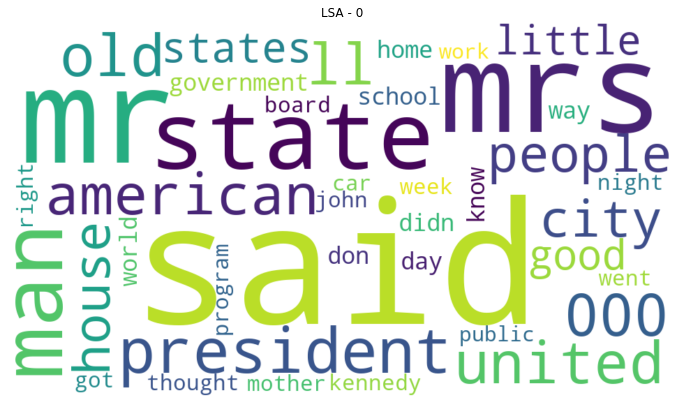

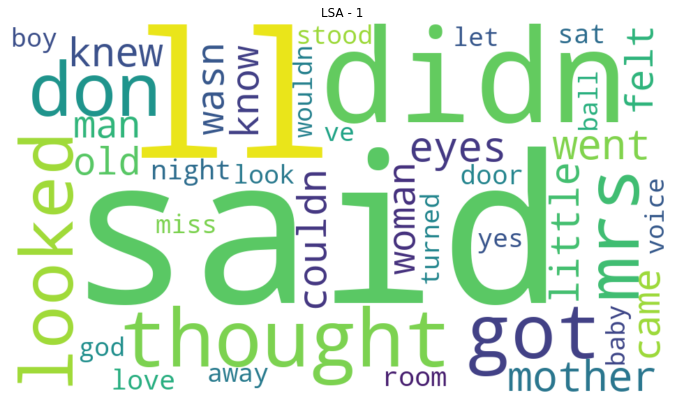

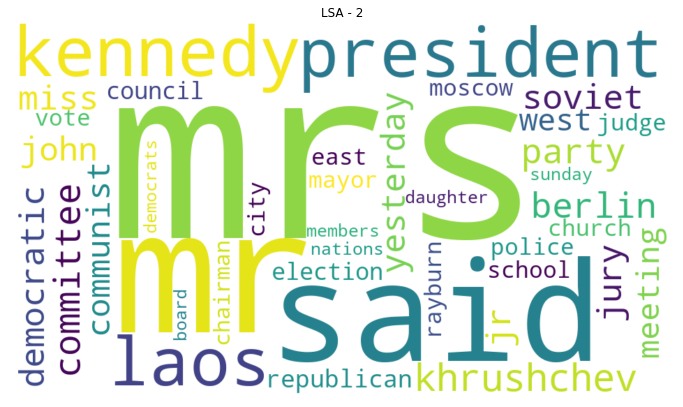

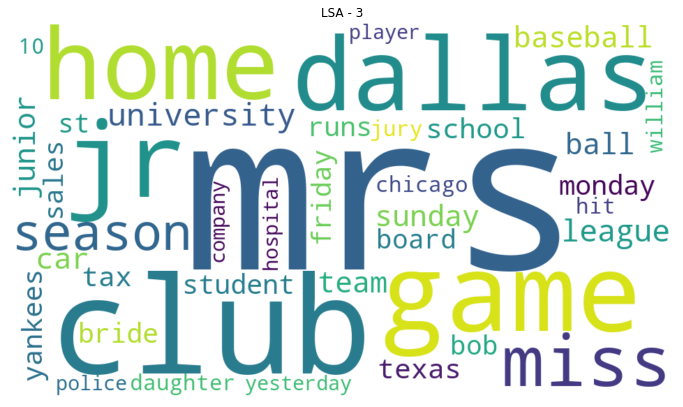

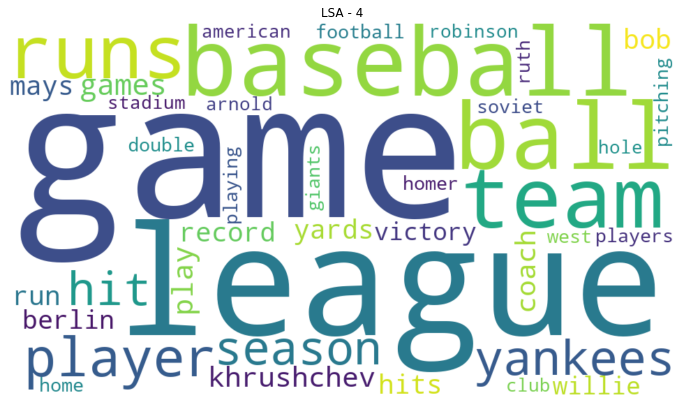

In [88]:
wordcloud_topics(svd_model, tfidf_text_vectorizer.get_feature_names_out(),wc_title="LSA")

Q: How does your five-topic LSA model compare to the original Brown categories? 

A:
1. Category 0 - This category seems to combine the government and news categories from the original dataframe, featuring words such as state , president, kennedy, united, american, and more.

2. Category 1 - This category has a few nonsensial leading words such as ll, didn, and don. Beyond this, it overlaps considerably with the Romance category through words such as woman, mother, eyes, etc.

3. Category 2 - This is largely an accurate mapping to the editorial category.

4. Category 3 - This category suggests that it might be an allegory to the Hobbies category based on words such as "baseball", "game","ball", etc, but the wordcloud created for hobbies seems to not include any of those words, which means there's no meaningful overlap although the subjects seem to be similar.

5. Category 4 - This category is strange because it combines the editorial and government categories by invoking the name of both Krushchev and berlin, but also heavily revolves around sports terminology such as baseball and game, words that did not appear when we generated a word cloud for the hobbies category.

In [90]:
# call display_topics on your model
#Our previously defined function for evaluating the topic model can also be used:
display_topics(svd_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.14)
  mr (1.73)
  said (1.05)
  kennedy (0.81)
  president (0.77)

Topic 03
  mrs (30.38)
  club (6.70)
  game (6.40)
  jr (5.81)
  dallas (5.50)

Topic 04
  game (4.33)
  league (3.09)
  baseball (3.06)
  ball (2.94)
  team (2.81)


Q: What is your interpretation of the display topics output? 

A: The output shows us the percentage contribution of each word to defining the topic.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [96]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])

In [102]:
# Fit your LDA model here
lda_model = LatentDirichletAllocation(n_components = 5, random_state=42)
W_lda_matrix = lda_model.fit_transform(count_text_vectors)
H_lda_matrix = lda_model.components_

In [103]:
# Call `display_topics` on your fitted model here
display_topics(lda_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  home (0.46)
  right (0.35)
  game (0.35)
  way (0.34)
  set (0.34)

Topic 01
  state (0.89)
  development (0.57)
  states (0.51)
  program (0.46)
  use (0.44)

Topic 02
  said (0.93)
  mr (0.73)
  president (0.63)
  state (0.49)
  mrs (0.48)

Topic 03
  feed (0.90)
  general (0.73)
  business (0.70)
  property (0.69)
  shall (0.67)

Topic 04
  said (1.56)
  man (0.62)
  little (0.62)
  old (0.59)
  good (0.53)


Q: What inference do you draw from the displayed topics for your LDA model? 

A: At the text level (as opposed to the paragraph level), there aren't any words that strongly define each category, with no word having a contribution over 1.5% among those printed, though topics 1 and 2 do seem to mimic the Brown categories of government and editorials to some extent. We might benefit from stronger performance by doing this at the paragraph level.


Q: How does your five-topic LDA model compare to the original Brown categories? 

A: As mentioned, topics 1 and 2 seem to map somewhat to government and editorial categories, as well as topic 0, which overlaps with the hobbies category by its heavy reliance on the word "home". The other two categories don't have any intuitive mapping to the Brown categories.

In [104]:
lda_display = pyLDAvis.sklearn.prepare(lda_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

c:\users\fkrasovsky\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\users\fkrasovsky\appdata\local\programs\python\python38\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [105]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: Topics 2 and 3 constitute almost half the documents. None of the frequency bars are decreasing quickly, so none of the topics are particularly well pronounced. This applies moreso to topic 1 and 4. Topics 2 and 3 have some overlap with one another, which lines up with the fact that they both heavily reference government and politics. Topic 4 has strong overlap with Topic 2, and serves as a business-related subset of topic 2, which focuses on politics and economics writ large. **This means that five topics is probably too many for practical purposes and we could scale down.**

This argument is further supplemented by the relatively poorly pronounced topic 1 - although it is distant from other clusters, it also doesn't identify any apparent theme, and could probably be removed as well. Topic 5 is largely characterized by verbs, with the strongest contribution coming from the verb "said", which provides very little value. **This means we could get better fidelity for these clusters through cleaning out verbs and focusing more on nouns and adjectives.**
